**ANÁLISE EXPLORATÓRIA DAS REQUISIÇÕES**

In [ ]:
#1. INSTALAR E IMPORTAR BIBLIOTECAS

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [ ]:
#2. CARREGAR A BASE DE DADOS

from google.colab import files
import pandas as pd

# Abre o botão para escolher o arquivo (CSV)
uploaded = files.upload()

# Pega o nome do primeiro arquivo carregado
filename = list(uploaded.keys())[0]

# Lê o CSV com separador ";"
df = pd.read_csv(filename, sep=";")

# Normaliza os nomes das colunas (tudo minúsculo, sem espaços)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Mostra as 5 primeiras linhas da base
df.head()

Saving base_interpolada_ajustada.csv to base_interpolada_ajustada.csv


,unnamed:_0,timestamp,hora_dia,dia_semana,reqs,trafego_mbps,usuarios_ativos,temp_ambiente_c,uso_cpu_%,uso_ram_%,demanda_energia_kw,pressao_resfriamento_bar,consumo_agua_m3
0,0,27/04/2025 00:00,0.0,6.0,69449.0,29.0,117723.0,196.727.316.264.116,499.748.985.958.567,455.996.671.329.026,530.079.647.224.932,174.496.546.737.546,660.898.757.399.281
1,1,27/04/2025 01:00,1.0,6.0,47088.0,10.0,114217.0,240.283.539.325.478,502.980.754.117.866,495.319.111.802.969,520.202.647.122.302,181.191.568.604.715,598.742.273.910.559
2,2,27/04/2025 02:00,2.0,6.0,53537.0,26.0,129156.0,257.828.952.346.305,516.168.423.545.679,451.117.779.195.156,536.064.628.473.584,18.448.276.402.923,656.310.816.508.777
3,3,27/04/2025 03:00,3.0,6.0,79260.0,25.0,147527.0,276.024.703.368.258,482.714.372.112.768,352.881.681.706.346,515.557.007.356.046,185.539.424.110.877,681.675.992.220.667
4,4,27/04/2025 04:00,4.0,6.0,32243.0,10.0,135722.0,267.287.596.136.226,492.141.386.901.896,445.551.318.589.734,532.525.341.623.776,184.700.208.765.529,602.714.808.206.127


In [ ]:
#3. CONVERTER A COLUNA reqs

df["reqs"] = pd.to_numeric(df["reqs"], errors="coerce")
print("Valores faltantes na coluna reqs:", df["reqs"].isna().sum())

Valores faltantes na coluna reqs: 0


In [ ]:
#4. ESTATÍSTICA DESCRITIVA

# Seleciona a coluna reqs, ignorando valores vazios
reqs = df["reqs"].dropna()

# Estatísticas básicas
print(reqs.describe().round(2))

count       708.00
mean      72343.25
std       40532.28
min       15127.00
25%       37414.50
50%       61124.00
75%      101299.75
max      195233.00
Name: reqs, dtype: float64


**Análise:**

A média é de, aproximadamente, 72 mil, sendo maior que a mediana que é, aproximadamente, 61 mil, temos que alguns valores altos puxam a média.

Considerando que o DP é de, aproximandamente, 40 mil, temos uma variabilidade relativa de 55,6% (DP/Média = 40/72). Ou seja, temos um DP padrão alto, uma vez, que há uma variação considerável em que o DP se distancia consideravelmente da média, sugerindo que os dados não estão concentrados em torno do valor central.

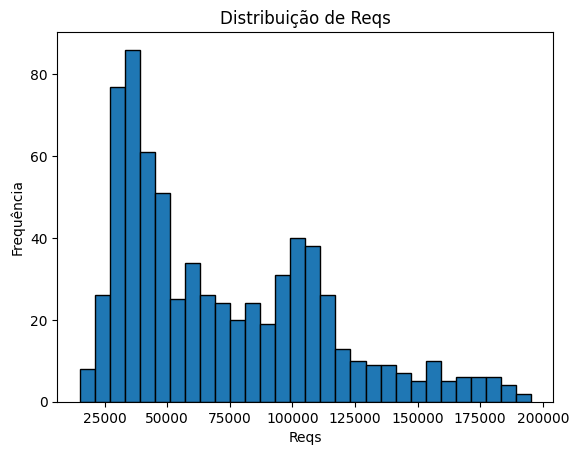

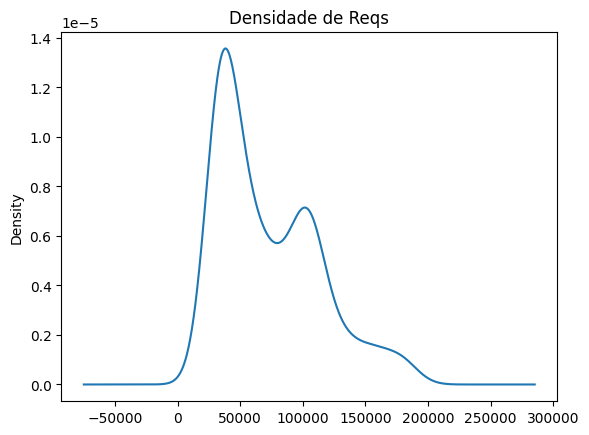

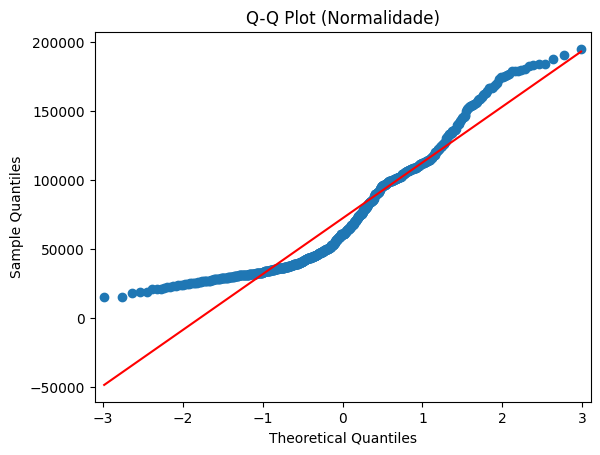

In [7]:
#5. VISUALIZAÇÃO DA DISTRIBUIÇÃO

# Histograma: mostra a frequência dos valores
plt.hist(reqs, bins=30, edgecolor="black")
plt.title("Distribuição de Reqs")
plt.xlabel("Reqs")
plt.ylabel("Frequência")
plt.show()

# Gráfico de densidade: curva suave que mostra onde estão mais dados
reqs.plot(kind="kde")
plt.title("Densidade de Reqs")
plt.show()

# Q-Q plot: compara a distribuição com uma normal (linha reta seria ideal)
sm.qqplot(reqs, line='s')
plt.title("Q-Q Plot (Normalidade)")
plt.show()

In [6]:
#6. DETECÇÃO DE OUTLIERS

# Método IQR
Q1 = reqs.quantile(0.25)   # Primeiro quartil (25%)
Q3 = reqs.quantile(0.75)   # Terceiro quartil (75%)
IQR = Q3 - Q1              # Intervalo

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_iqr = reqs[(reqs < limite_inferior) | (reqs > limite_superior)]

print("Outliers pelo IQR:", len(outliers_iqr))

# Método Z-score (distância em desvios da média)
z_scores = stats.zscore(reqs)
outliers_z = reqs[abs(z_scores) > 3]

print("Outliers pelo Z-score:", len(outliers_z))

Outliers pelo IQR: 0
Outliers pelo Z-score: 1


**Análise:**

O Intervalo Interquartil (IQR) não detectou outliers, considerando que o máximo (195.233) está próximo do limite IQR (197 mil).

In [ ]:
#7. CORRELAÇÃO COM OUTRAS VARIAVEIS

# Seleciona apenas colunas numéricas
num_cols = df.select_dtypes(include="number")

# Matriz de correlação de Pearson
corr = num_cols.corr(method="pearson")

# Correlações da coluna reqs com as demais
print(corr["reqs"].sort_values(ascending=False))


reqs               1.000000
trafego_mbps       0.893946
usuarios_ativos    0.846880
hora_dia           0.398093
unnamed:_0        -0.260449
dia_semana        -0.338555
Name: reqs, dtype: float64


In [8]:
#8. TESTES DE NORMALIDADE

# Shapiro-Wilk
stat, p = stats.shapiro(reqs)
print("Shapiro-Wilk p-valor:", p)

# D’Agostino
k2, p = stats.normaltest(reqs)
print("D’Agostino p-valor:", p)

# Anderson-Darling
result = stats.anderson(reqs)
print("Anderson-Darling estatística:", result.statistic)
print("Valores críticos:", result.critical_values)


# Se o p-valor < 0.05, rejeitamos a hipótese de que os dados são normais.

Shapiro-Wilk p-valor: 3.742956031330856e-20
D’Agostino p-valor: 5.33895399873529e-15
Anderson-Darling estatística: 20.54827941390056
Valores críticos: [0.573 0.652 0.783 0.913 1.086]


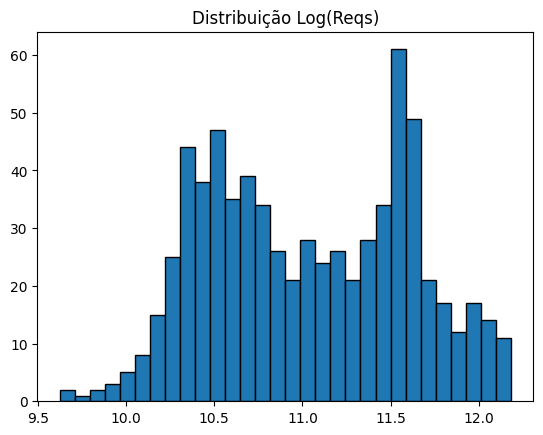

Shapiro-Wilk (log) p-valor: 4.4524260935219266e-12


In [9]:
#9. TRANSFORMAÇÃO LOGARÍTMICA (OPCIONAL)

# Aplica log natural para reduzir assimetria
import numpy as np
reqs_log = np.log(reqs)

# Novo histograma
plt.hist(reqs_log, bins=30, edgecolor="black")
plt.title("Distribuição Log(Reqs)")
plt.show()

# Teste de normalidade novamente
stat, p = stats.shapiro(reqs_log)
print("Shapiro-Wilk (log) p-valor:", p)